In [4]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_tasks_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names
from samplers import get_data_sampler
from tasks import get_task_sampler
from train import config_load_special
import numpy as np
from utils.manual_solvers import w_sig_NGgenerator, w_sig_NGposterior, w_sig_ridge
import copy



%matplotlib inline
%load_ext autoreload
%autoreload 2


model_path_const = 
model_path_vary = 



all_experiments = ["const_x_model", "vary_x_model"]

## load everything

model_dic = {}
config_dic = {}
ys_dic = {}
mus_dic = {}
sigs_dic = {}
exempt_dic = {}
predmu_dic = {}
predsigma_dic = {}

bayes_mus_dic = {}
bayes_sigs_dic = {}
ridge_mus_dic = {}
ridge_sigs_dic = {}


for experiment in all_experiments:

    if experiment == "const_x_model":
        model_path = model_path_const
    elif experiment == "vary_x_model":
        model_path = model_path_vary

    model, _ = get_model_from_run(model_path)

    config = config_load_special(model_path)

    model_dic[experiment] = model

    config_dic[experiment] = config

lower_upper_pairs = {
    "larger_cov": ([4] * 8, [4] * 8),
    "decreasing_diag": ([8*i**(-1) for i in range(1, 9)], [8*i**(-1) for i in range(1, 9)]),
    "shrinking_diag": ([8*i**(-2) for i in range(1, 9)], [8*i**(-2) for i in range(1, 9)]),
    "rotation": ([8*i**(-1) for i in range(1, 9)], [8*i**(-1) for i in range(1, 9)]),
}


# generate test data
sample_key = list(config_dic.keys())[0]

n_dims = config_dic[sample_key].model.n_dims
batch_size = config_dic[sample_key].training.batch_size



for x_schema in list(lower_upper_pairs.keys()):

    data_sampler = get_data_sampler("varsig", n_dims)
    
    xs = data_sampler.sample_xs(b_size=batch_size, n_points=config_dic[sample_key].training.curriculum.points.end, 
                                upper_limit_vec=lower_upper_pairs[x_schema][1], lower_limit_vec=lower_upper_pairs[x_schema][0])
    if x_schema == "rotation":
        for row in range(len(xs)):

            U, _, _ = torch.linalg.svd(torch.randn(n_dims, n_dims))
            xs[row, :, :] = xs[row, :, :] @ U


    for pretrained_model in all_experiments:

        new_exp = pretrained_model + "_on_" + x_schema 


        ## reset w and sigma of task samplers

        mu0 = np.ones(n_dims)

        ## gamma(a, b), mean = a/b, variance = a/b^2
        ## when training, we let a/b=1 and b relatively large
        b0 = 20
        a0 = 20

        new_ws, new_sigs = w_sig_NGgenerator(a0, b0, mu0, n_dims, batch_size)

        config_dic[new_exp] = copy.deepcopy(config_dic[pretrained_model])

        config_dic[new_exp].training.task_kwargs["pool_dict"]["w"] = torch.Tensor(np.expand_dims(new_ws, axis=-1))
        config_dic[new_exp].training.task_kwargs["pool_dict"]["sigma"] = torch.Tensor(new_sigs)
        config_dic[new_exp].training.task_kwargs["pool_dict"]["exempt"] = np.zeros(batch_size)

        task_sampler = get_task_sampler(
            config_dic[new_exp].training.task,
            n_dims,
            batch_size,
            **config_dic[new_exp].training.task_kwargs
        )

        task = task_sampler()

        mus, ys, sigma, exemps = task.eval_with_mu_sigma_exempt(xs)

        ys_dic[new_exp] = ys
        mus_dic[new_exp] = mus
        exempt_dic[new_exp]= exemps
        sigs_dic[new_exp] = sigma


        with torch.no_grad():
            pred = model_dic[pretrained_model](xs, ys)

        predmu_dic[new_exp] = pred[:, :, 0]
        predsigma_dic[new_exp] = pred[:, :, 1]

        posterior_mu = np.zeros(predmu_dic[new_exp].shape)
        posterior_sigma = np.zeros(predmu_dic[new_exp].shape)
        ridge_mu = np.zeros(predmu_dic[new_exp].shape)
        ridge_sigma = np.zeros(predmu_dic[new_exp].shape)


        for selected_index in range(len(predmu_dic[new_exp])):

            estimated_ws, estimated_sigs = w_sig_NGposterior(xs.numpy()[selected_index], ys.numpy()[selected_index], a0, b0, mu0)

            real_estimated_ws = np.zeros(estimated_ws.shape)
            real_estimated_sigs = np.zeros(estimated_sigs.shape)

            real_estimated_ws[0] = mu0
            real_estimated_sigs[0] = np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2))

            real_estimated_ws[1:] = estimated_ws[:-1]
            real_estimated_sigs[1:] = estimated_sigs[:-1]

            posterior_mu[selected_index, :] = (np.expand_dims(xs.numpy()[selected_index, :], axis=1) @ np.expand_dims(real_estimated_ws, axis=-1))[:, 0, 0]
            posterior_sigma[selected_index, :] = real_estimated_sigs


            ridge_ws, ridge_sigs = w_sig_ridge(xs.numpy()[selected_index], ys.numpy()[selected_index])
            
            ridge_mu[selected_index, 1:] = (np.expand_dims(xs.numpy()[selected_index, 1:], axis=1) @ np.expand_dims(ridge_ws[:-1], axis=-1))[:, 0, 0]
            ridge_sigma[selected_index, 1:] = ridge_sigs[:-1]



        bayes_mus_dic[new_exp] = posterior_mu
        bayes_sigs_dic[new_exp] = posterior_sigma
        ridge_mus_dic[new_exp] = ridge_mu
        ridge_sigs_dic[new_exp] = ridge_sigma

# 3min

## Compare to Bayes

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


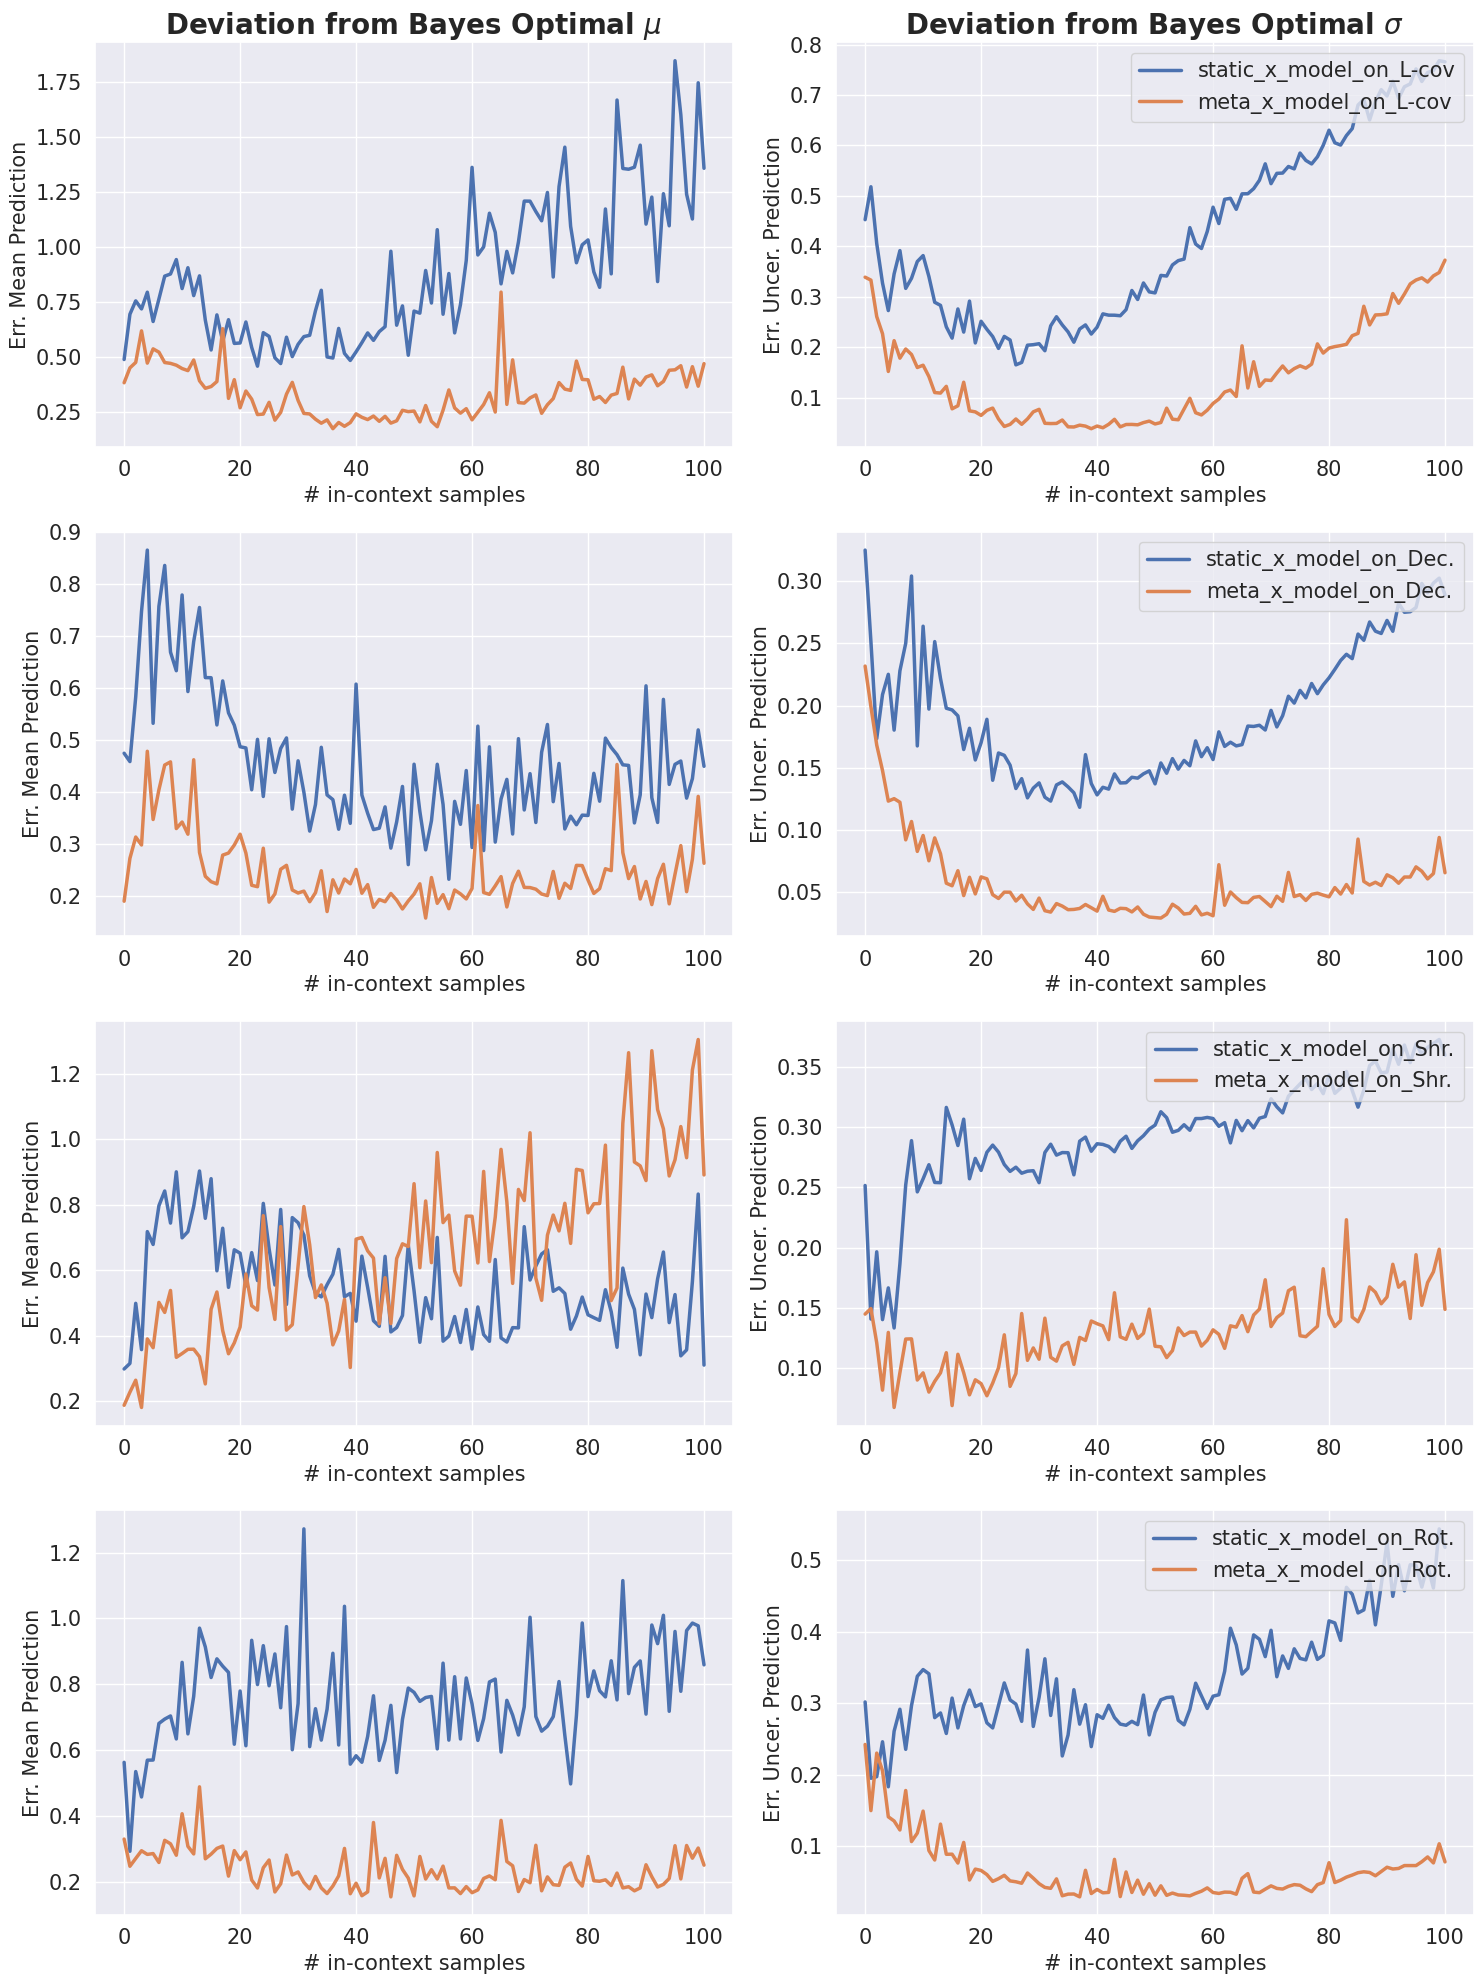

In [7]:
import numpy as np
import matplotlib.pyplot as plt



fig, axs = plt.subplots(4, 2, figsize=(15, 20))


# idx = 4
# Data for the first line chart
x = np.arange(101)

def softplus(arr):
    return np.log(1+np.exp(arr))

# ["larger_cov", "decreasing_diag", "shrinking_diag", "rotation"]
ax_row = 0

exp_name_dic = {
    "const_x_model": "static_x_model",
    "vary_x_model": "meta_x_model"
}

schema_dic = {
    "larger_cov": "L-cov", 
    "decreasing_diag": "Dec.", 
    "shrinking_diag": "Shr.", 
    "rotation": "Rot."
}

for x_schema in ["larger_cov", "decreasing_diag", "shrinking_diag", "rotation"]:


    for pretrained_model in all_experiments:


        new_exp = pretrained_model + "_on_" + x_schema

        mus = mus_dic[new_exp].numpy()
        ys = ys_dic[new_exp].numpy()
        preds = predmu_dic[new_exp].numpy()
        bayes_mu_preds = bayes_mus_dic[new_exp]
        bayes_sigma_preds = bayes_sigs_dic[new_exp]

        # plt.plot(x, np.abs(preds-ys).mean(axis=0), label=experiment +  '_devi_y')
        axs[ax_row, 0].plot(x, np.abs(preds-bayes_mu_preds).mean(axis=0), label=new_exp,  linewidth=2.5)


        sigma = sigs_dic[new_exp].numpy()
        # ys = ys_dic[experiment].numpy()
        
        pred_sigma = softplus(predsigma_dic[new_exp].numpy())

        # full_sigma  = np.tile(sigma.reshape(-1,1), (1, pred_sigma.shape[1]))

        # plt.plot(x, np.abs(preds-ys).mean(axis=0), label=experiment +  '_devi_y')
        new_exp_legend = exp_name_dic[pretrained_model] + "_on_" + schema_dic[x_schema]
        axs[ax_row, 1].plot(x, np.abs(pred_sigma-bayes_sigma_preds).mean(axis=0), label=new_exp_legend,  linewidth=2.5)

        axs[ax_row, 1].xaxis.set_tick_params(labelsize=15)
        axs[ax_row, 1].yaxis.set_tick_params(labelsize=15)

    # Adding labels and title
    axs[ax_row, 0].set_xlabel('# in-context samples', fontsize="15")
    axs[ax_row, 0].set_ylabel('Err. Mean Prediction', fontsize="15")
    # ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Adding legend

    axs[ax_row, 1].set_xlabel('# in-context samples', fontsize="15")
    axs[ax_row, 1].set_ylabel('Err. Uncer. Prediction', fontsize="15")
    axs[ax_row, 1].legend(loc='upper right', fontsize="15")  # Adding legend

    if ax_row == 0:

        axs[ax_row, 0].set_title('Deviation from Bayes Optimal $\mu$', fontsize="20", fontweight='bold')
        axs[ax_row, 1].set_title('Deviation from Bayes Optimal $\sigma$', fontsize="20", fontweight='bold')

    axs[ax_row, 0].xaxis.set_tick_params(labelsize=15)
    axs[ax_row, 0].yaxis.set_tick_params(labelsize=15)
    axs[ax_row, 1].xaxis.set_tick_params(labelsize=15)
    axs[ax_row, 1].yaxis.set_tick_params(labelsize=15)




    ax_row += 1







# Displaying the plot
plt.tight_layout()
plt.savefig('figures/exp_8_covX.eps', format='eps')
plt.savefig('figures/exp_8_covX.png', format='png')
plt.show()



In [11]:
import pandas as pd

all_experiments = ["const_x_model", "vary_x_model"]
all_schema = ["larger_cov", "decreasing_diag", "shrinking_diag", "rotation"]

mu_table = np.zeros((4, 8))
sig_table = np.zeros((4, 8))

for row in range(4):
    schema = all_schema[row]
    for big_co in range(4):
        step_of_t = (big_co+1) * 20
        for sub_model in range(2):
            model_name = all_experiments[sub_model]
            new_exp = model_name + "_on_" + schema

            preds = predmu_dic[new_exp].numpy()
            bayes_mu_preds = bayes_mus_dic[new_exp]
            bayes_sigma_preds = bayes_sigs_dic[new_exp]


            sigma = sigs_dic[new_exp].numpy()
        
            pred_sigma = softplus(predsigma_dic[new_exp].numpy())

            
            
            mu_table[row, 2*big_co+sub_model] = np.abs(preds-bayes_mu_preds).mean(axis=0)[step_of_t]
            sig_table[row, 2*big_co+sub_model] = np.abs(pred_sigma-bayes_sigma_preds).mean(axis=0)[step_of_t]


# mu_table

mu_table

array([[0.61412249, 0.26934761, 0.49513164, 0.17071121, 0.81938632,
        0.18958449, 1.33430024, 0.35972877],
       [0.74279035, 0.16782036, 0.3300764 , 0.14031197, 0.30839191,
        0.14676465, 0.42381371, 0.18331126],
       [0.58904637, 0.37515808, 0.39294586, 0.37780075, 0.46474914,
        0.53315886, 0.39585762, 0.56754498],
       [0.69786269, 0.1895024 , 0.5365194 , 0.31430737, 0.62598597,
        0.17134163, 0.78148267, 0.21283871]])

In [12]:
sig_table

array([[0.147958  , 0.05849422, 0.22287016, 0.03052162, 0.42222956,
        0.05195972, 0.65644866, 0.13802182],
       [0.16016587, 0.03827085, 0.13984609, 0.02526244, 0.17835021,
        0.03173462, 0.234098  , 0.03718079],
       [0.15952318, 0.10433376, 0.20866964, 0.11345682, 0.22857255,
        0.21350962, 0.27892857, 0.15377523],
       [0.31042214, 0.04794086, 0.22486802, 0.03124795, 0.31105498,
        0.04868248, 0.51682097, 0.0642153 ]])